In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.model_selection import train_test_split

We perform transfer learning on Sweden only, train on Svealand, N. Norrland, and S. Norrland. Evaluate on Götaland.

In [59]:
#To save results
df = pd.DataFrame()

In [60]:
#define predictor columns and target column
predictor_columns = ['zq5', 'zq10', 'zq15', 'zq20', 'zq25', 'zq30', 'zq35', 'zq40', 'zq45', 'zq50', 'zq55', 'zq60',
                     'zq65', 'zq70', 'zq75', 'zq80', 'zq85', 'zq90', 'zq95', 'pzabovezmean', 'pzabove2',
                     'zpcum1', 'zpcum2', 'zpcum3', 'zpcum4', 'zpcum5', 'zpcum6', 'zpcum7', 'zpcum8', 'zpcum9']

target_column = 'D_AVERAGE'

data_sweden = pd.read_csv('Image_data\merged_data_permanent_cleaned.csv', index_col = [0])

#rename 'Hgv' to 'H_AVERAGE'
data_sweden = data_sweden.rename(columns = {"Dgv": "D_AVERAGE"})

#for training and testing on Sweden only (1 is Götaland, 2 is Svealand, 3 is S. Norrland, 4 is N. Norrland)
#The test region should be listed first here!
data_train_sweden_1 = data_sweden[data_sweden['area_code'] == 4]
data_train_sweden_2 = data_sweden[data_sweden['area_code'] == 2]
data_train_sweden_3 = data_sweden[data_sweden['area_code'] == 3]
data_train_sweden_4 = data_sweden[data_sweden['area_code'] == 1]

#combine datasets from the other regions
data_train_sweden_234 = pd.concat([data_train_sweden_2, data_train_sweden_3])
data_train_sweden_234 = pd.concat([data_train_sweden_234, data_train_sweden_4])
data_train_sweden_1, data_test_sweden_1 = train_test_split(data_train_sweden_1, test_size = 0.2, random_state = 9)
data_train_sweden_234

#evaluate and train on latvia instead (keep naming for simplicity, just overwrite existing target data)
#data_latvia = pd.read_csv('Latvian_Image_data\merged_data_cleaned.csv')
#data_train_sweden_1, data_test_sweden_1 = train_test_split(data_latvia, test_size = 0.95, random_state = 1)
print(len(data_train_sweden_1))

1356


C:\Users\Dag Bjornberg\AppData\Local\Temp\ipykernel_22184\2733609877.py:8: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_sweden = pd.read_csv('Image_data\merged_data_permanent_cleaned.csv', index_col = [0])


In [61]:
#"General" base dataset (to use for transfer)
ahat_train = np.array(data_train_sweden_234[predictor_columns])
bhat_train = np.array(data_train_sweden_234[target_column])

#Specific train and test set
a_train = np.array(data_train_sweden_1[predictor_columns])
b_train = np.array(data_train_sweden_1[target_column])

x_test = np.array(data_test_sweden_1[predictor_columns])
y_test = np.array(data_test_sweden_1[target_column])



In [62]:
#rmse computation
def compute_rmse(preds, ground_truth):
    rmse = np.sqrt(np.mean(np.square(preds-ground_truth)))
    return rmse

### Define boosting method (We will consider L2)

### Perform LS_TreeBoost

# Decay

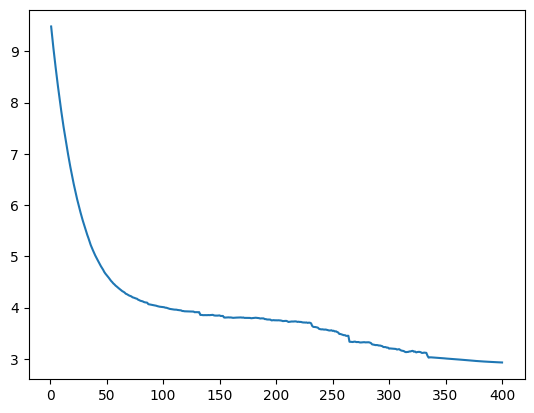

In [63]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
# **Final Prediction using All Trees**
def boosted_prediction(X_new, y_train, model_tray, leaf_means_tray, v=0.03):
    """Compute the final LAD TreeBoost prediction."""
    F_pred = np.full_like(X_new[:, 0], np.mean(y_train))  # Start with initial mean
    
    for i, tree in enumerate(model_tray):
        leaf_nodes = tree.apply(X_new)  # Find leaf for each X_new
        # Add the median residual for the region (leaf) of each X_new
        F_pred += v*np.array([leaf_means_tray[i][leaf] for leaf in leaf_nodes])
    
    return F_pred

#alpha is unused, but remains here in case 
def LSTreeBoost(a, b, ahat, bhat, alpha, M = 100, v = 0.03):
    # Initialize the model with the mean of y
    y = np.concatenate((b, bhat))
    x = np.concatenate((a, ahat))
    F = np.full_like(y, np.mean(b))  #initial guess
    model_tray = []  # Store trees
    leaf_means_tray = []  # Store leaf-means (same as gamma coefficients for L2-loss)
    losses = []
    A = len(bhat)
    num_indices = A

    # Perform boosting iterations
    for m in range(M):
        # Compute residuals: r_i = y_i - F(x_i)
        y_residuals = (y - F)

        # Train a decision tree on the residuals
        clf = DecisionTreeRegressor(max_depth=2, min_samples_leaf = 25)
        clf.fit(x, y_residuals)
        model_tray.append(clf)  # Store trained tree

        # Get the leaf node assignments for each data point
        leaf_nodes = clf.apply(x)



        # Compute mean residual for each leaf
        unique_leaves = np.unique(leaf_nodes)
        leaf_means = {
            leaf: np.mean(y_residuals[leaf_nodes == leaf])  
            for leaf in unique_leaves
        }
        leaf_means_tray.append(leaf_means)  # Store median updates

        # Update F by adding the mean residual of the corresponding leaf for each sample
        for leaf in unique_leaves:
            F[leaf_nodes == leaf] += v*leaf_means[leaf]  # Update the samples in that region
        mse = compute_rmse(F, y)  # LSTreeBoost minimizes MSE
        losses.append(mse)
        
        # update training dataset
        num_indices -= int(A/(M+1)*1.2) #hardcoded here, but this worked ok
        num_indices = max(num_indices, 0)
        #select a subsample of the source dataset, then decay the source dataset for next iteration
        selected_indices = np.random.choice(len(bhat), num_indices, replace=False)
        ahat = ahat[selected_indices]
        bhat = bhat[selected_indices]
        x = np.concatenate((a, ahat))
        y = np.concatenate((b, bhat))
        #print(len(x))
        combined_indices = np.concatenate((np.arange(len(b)), selected_indices + len(b)))  # Indices for original + new data
        
        # Reorder F based on the combined indices to reflect the updated structure
        F = F[combined_indices]

        
    return model_tray, leaf_means_tray, losses

#perform training and testing, save test_rmses
alpha_list = [1]
rmses = []
test_rmses = []
for alpha in alpha_list:
    model_tray, leaf_means_tray, losses = LSTreeBoost(a_train, b_train, ahat_train, bhat_train, alpha = alpha, M = 400)
    rmses.append(losses)
    # Test final LS TreeBoost function
    final_predictions = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)
    preds = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)
    rmse = compute_rmse(preds, y_test)
    test_rmses.append(rmse)
    





# Test final LS TreeBoost function
final_predictions = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)

plt.plot(np.linspace(1, len(losses), len(losses)), losses)

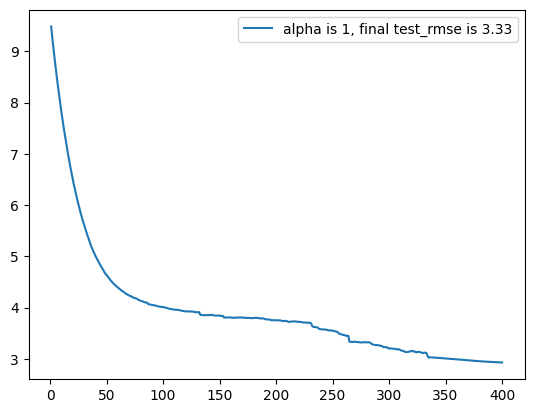

In [64]:
labels = []
for loss, rmse, alpha in zip(rmses, test_rmses, alpha_list):
    
    # Test final LS TreeBoost function
    final_predictions = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)

    plt.plot(np.linspace(1, len(loss), len(loss)), loss)
    labels.append(f'alpha is {alpha}, final test_rmse is {np.round(rmse, 2)}')
    
    plt.legend(labels)

#we only do it once, so we can add test result to dataframe    
df['decay'] = [test_rmses[0]]


# No Decay (combined dataset)

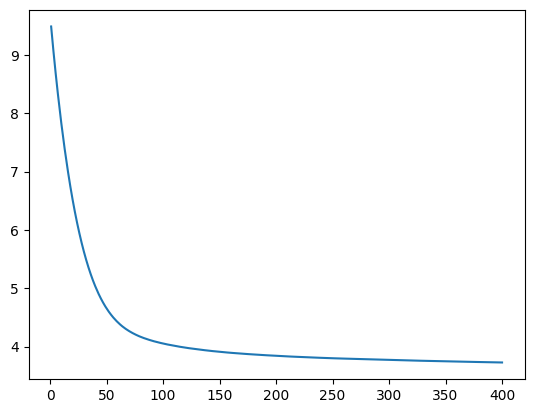

In [65]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
# **Final Prediction using All Trees**
def boosted_prediction(X_new, y_train, model_tray, leaf_means_tray, v=0.03):
    """Compute the final LAD TreeBoost prediction."""
    F_pred = np.full_like(X_new[:, 0], np.mean(y_train))  # Start with initial median
    
    for i, tree in enumerate(model_tray):
        leaf_nodes = tree.apply(X_new)  # Find leaf for each X_new
        # Add the median residual for the region (leaf) of each X_new
        F_pred += v*np.array([leaf_means_tray[i][leaf] for leaf in leaf_nodes])
    
    return F_pred

 
def LSTreeBoost(a, b, ahat, bhat, alpha, M = 100, v = 0.03):
    # Initialize the model with the median of y
    y = np.concatenate((b, bhat))
    x = np.concatenate((a, ahat))
    F = np.full_like(y, np.mean(b))  # F_0(x) = median(y)
    model_tray = []  # Store trees
    leaf_means_tray = []  # Store per-leaf median residuals
    losses = []
    A = len(bhat)
    num_indices = A

    # Perform boosting iterations
    for m in range(M):
        # Compute residuals: r_i = y_i - F(x_i)
        y_residuals = (y - F)

        # Train a decision tree on the residuals
        clf = DecisionTreeRegressor(max_depth=2, min_samples_leaf = 25)
        clf.fit(x, y_residuals)
        model_tray.append(clf)  # Store trained tree

        # Get the leaf node assignments for each data point
        leaf_nodes = clf.apply(x)



        # Compute median residual for each leaf
        unique_leaves = np.unique(leaf_nodes)
        leaf_means = {
            leaf: np.mean(y_residuals[leaf_nodes == leaf])  
            for leaf in unique_leaves
        }
        leaf_means_tray.append(leaf_means)  # Store median updates
        # Update F by adding the median residual of the corresponding leaf for each sample
        for leaf in unique_leaves:
            F[leaf_nodes == leaf] += v*leaf_means[leaf]  # Update the samples in that region
        mse = compute_rmse(F, y)  # LSTreeBoost minimizes MAE
        losses.append(mse)
        
        # update training dataset
        num_indices =  len(bhat)

        selected_indices = np.random.choice(len(bhat), num_indices, replace=False)
        ahat = ahat[selected_indices]
        bhat = bhat[selected_indices]
        x = np.concatenate((a, ahat))
        y = np.concatenate((b, bhat))
       # print(len(x))
        combined_indices = np.concatenate((np.arange(len(b)), selected_indices + len(b)))  # Indices for original + new data
        
        # Reorder F based on the combined indices to reflect the updated structure
        F = F[combined_indices]

        
    return model_tray, leaf_means_tray, losses

alpha_list = [1]
rmses = []
test_rmses = []
for alpha in alpha_list:
    model_tray, leaf_means_tray, losses = LSTreeBoost(a_train, b_train, ahat_train, bhat_train, alpha = alpha, M = 400)
    rmses.append(losses)
    # Test final LAD TreeBoost function
    final_predictions = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)
    preds = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)
    rmse = compute_rmse(preds, y_test)
    test_rmses.append(rmse)
    





# Test final LAD TreeBoost function
final_predictions = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)

plt.plot(np.linspace(1, len(losses), len(losses)), losses)

In [66]:
preds = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)
rmse = compute_rmse(preds, y_test)
rmse
df['no_decay'] = [rmse]

# Compare with previous implementation (standard Treeboost on Target data only)

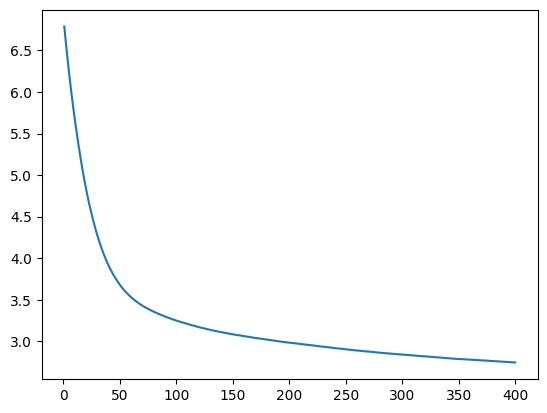

In [67]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
# **Final Prediction using All Trees**
def boosted_prediction(X_new, y_train, model_tray, leaf_means_tray, v=0.03):
    """Compute the final LAD TreeBoost prediction."""
    F_pred = np.full_like(X_new[:, 0], np.mean(y_train))  # Start with initial median
    
    for i, tree in enumerate(model_tray):
        leaf_nodes = tree.apply(X_new)  # Find leaf for each X_new
        # Add the median residual for the region (leaf) of each X_new
        F_pred += v*np.array([leaf_means_tray[i][leaf] for leaf in leaf_nodes])
    
    return F_pred

 
def LSTreeBoost(x, y, M = 100, v = 0.03):
    # Initialize the model with the median of y
    F = np.full_like(y, np.mean(y))  # F_0(x) = median(y)
    model_tray = []  # Store trees
    leaf_means_tray = []  # Store per-leaf median residuals
    losses = []

    # Perform boosting iterations
    for m in range(M):
        
        # Compute residuals: r_i = y_i - F(x_i)
        y_residuals = (y - F)

        # Train a decision tree on the residuals
        clf = DecisionTreeRegressor(max_depth=2, min_samples_leaf = 25)
        clf.fit(x, y_residuals)
        model_tray.append(clf)  # Store trained tree

        # Get the leaf node assignments for each data point
        leaf_nodes = clf.apply(x)



        # Compute median residual for each leaf
        unique_leaves = np.unique(leaf_nodes)
        leaf_means = {
            leaf: np.mean(y_residuals[leaf_nodes == leaf])  
            for leaf in unique_leaves
        }
        leaf_means_tray.append(leaf_means)  # Store median updates
        #print(leaf_means)
        # Update F by adding the median residual of the corresponding leaf for each sample
        for leaf in unique_leaves:
            F[leaf_nodes == leaf] += v*leaf_means[leaf]  # Update the samples in that region
        mse = compute_rmse(F, y)  # LSTreeBoost minimizes MAE
        losses.append(mse)
        
        
        
    return model_tray, leaf_means_tray, losses

model_tray, leaf_means_tray, losses = LSTreeBoost(a_train, b_train, M = 400)




# Test final LAD TreeBoost function
final_predictions = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)

plt.plot(np.linspace(1, len(losses), len(losses)), losses)

In [68]:
preds = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)
rmse = compute_rmse(preds, y_test)
rmse
df['no_transfer'] = [rmse]

# Finally, training and test on separate sets (complete transfer)

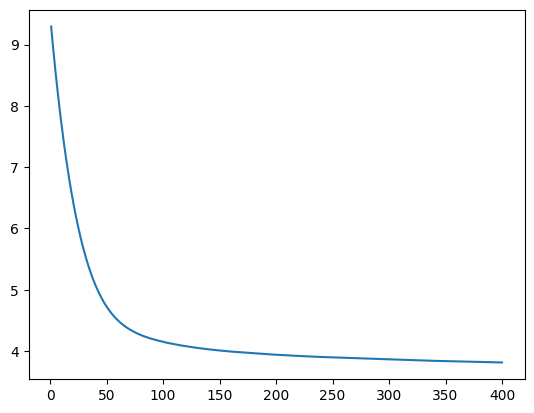

In [69]:
model_tray, leaf_means_tray, losses = LSTreeBoost(ahat_train, bhat_train, M = 400)




# Test final LAD TreeBoost function
final_predictions = boosted_prediction(x_test, bhat_train, model_tray, leaf_means_tray)

plt.plot(np.linspace(1, len(losses), len(losses)), losses)

In [70]:
preds = boosted_prediction(x_test, b_train, model_tray, leaf_means_tray)
rmse = compute_rmse(preds, y_test)
rmse
df['only_transfer'] = [rmse]

Text(0.5, 1.0, 'M: 400, training dataset size: 1356')

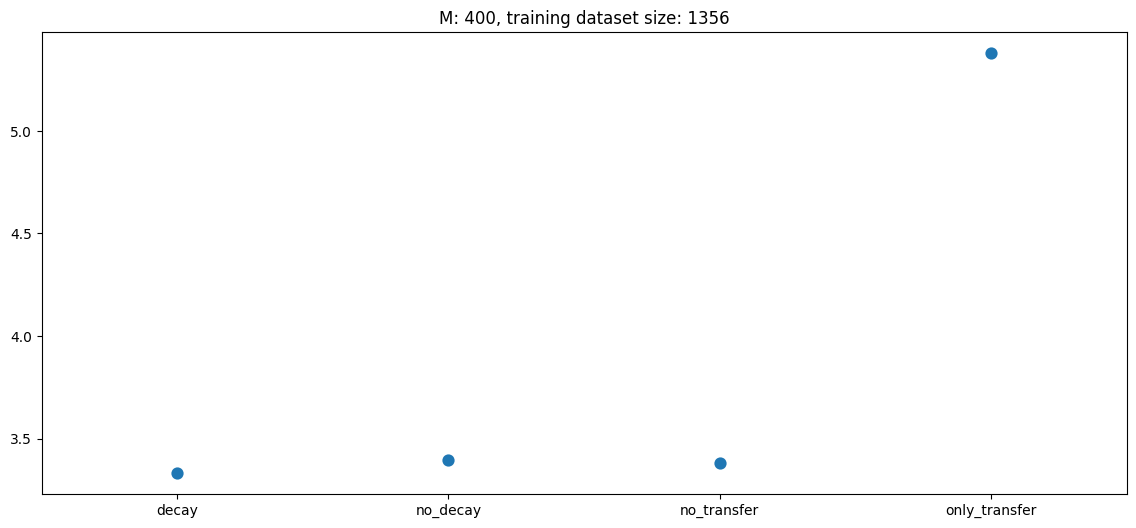

In [71]:
import seaborn as sns
plt.figure(figsize = (14,6))
sns.pointplot(df, linestyles = "None")
plt.title(f'M: 400, training dataset size: {len(data_train_sweden_1)}')


In [72]:
df

,decay,no_decay,no_transfer,only_transfer
0,3.331489,3.397305,3.380484,5.378701
